In [1]:
import os, re
import numpy as np

# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

In [2]:
# change to the root folder
base_dir = "/pscratch/sd/j/jibancat/gpy_dla_detection/"
os.chdir(base_dir)

try:
    assert "null_gp.py" in os.listdir("gpy_dla_detection")
except Exception as e:
    print(e)
    print("[Warning] Change the directory of base_dir to the path of your gpy_dla_detection repository.")

In [3]:
from gpy_dla_detection.desi_spectrum_reader import (
    DESISpectrumReader,read_all_catalogs,process_single_folder,read_single_folder
)  # Assuming you have DESISpectrumReader implemented


In [4]:
def find_high_snr_z_spectrum(reader, snr_threshold=10, redshift_threshold=3.2):
    """
    Finds the first spectrum with redshift > redshift_threshold and high SNR > snr_threshold.

    Parameters:
    ----------
    reader : DESISpectrumReader
        The DESI spectrum reader object containing all spectra and redshift data.
    snr_threshold : float, optional
        The minimum signal-to-noise ratio to consider as "high SNR" (default is 10).
    redshift_threshold : float, optional
        The minimum redshift to consider (default is 3.2).

    Returns:
    --------
    spectrum_id : str
        The ID of the first spectrum that matches the criteria.
    spectrum_data : namedtuple
        The spectrum data (wavelengths, flux, noise variance, pixel mask).
    z_qso : float
        The redshift of the chosen spectrum.
    """
    redshift_data = reader.get_redshift_data()
    all_spectrum_ids = reader.get_all_spectrum_ids()

    # Loop through all spectra
    for idx, spectrum_id in enumerate(all_spectrum_ids):
        z_qso = redshift_data['Z'][idx]

        # Check if redshift is above the threshold
        if z_qso > redshift_threshold:
            # Get spectrum data
            spectrum_data = reader.get_spectrum_data(spectrum_id)
            flux = spectrum_data.flux
            noise_variance = spectrum_data.noise_variance

            # Calculate SNR (flux / sqrt(noise_variance)) - ignoring masked pixels (NaNs)
            snr = flux / np.sqrt(noise_variance)
            mean_snr = np.nanmean(snr)  # Mean SNR for the spectrum

            # Check if the mean SNR is above the threshold
            if mean_snr > snr_threshold:
                print(f"Found spectrum with redshift {z_qso:.2f} and SNR {mean_snr:.2f}")
                return spectrum_id, spectrum_data, z_qso

    # If no spectrum is found that matches the criteria
    print(f"No spectrum found with redshift > {redshift_threshold} and SNR > {snr_threshold}")
    return None, None, None


## DESI Spectra on the GP-DLA Finder

In [5]:
import glob

all_filenames = glob.glob("/global/cfs/cdirs/desi/mocks/lya_forest/develop/london/qq_desi_y3/v5.9.5/mock-0/jura-124/spectra-16/*/*")

In [6]:
folder_path = all_filenames[21]
reader = process_single_folder(folder_path)

INFO:spectra.py:391:read_spectra: iotime 0.195 sec to read spectra-16-724.fits at 2024-10-07T12:24:33.754322
Processed spectra from /global/cfs/cdirs/desi/mocks/lya_forest/develop/london/qq_desi_y3/v5.9.5/mock-0/jura-124/spectra-16/7/724/spectra-16-724.fits
Processed redshift catalog from /global/cfs/cdirs/desi/mocks/lya_forest/develop/london/qq_desi_y3/v5.9.5/mock-0/jura-124/spectra-16/7/724/zbest-16-724.fits


Found spectrum with redshift 3.52 and SNR 5.96


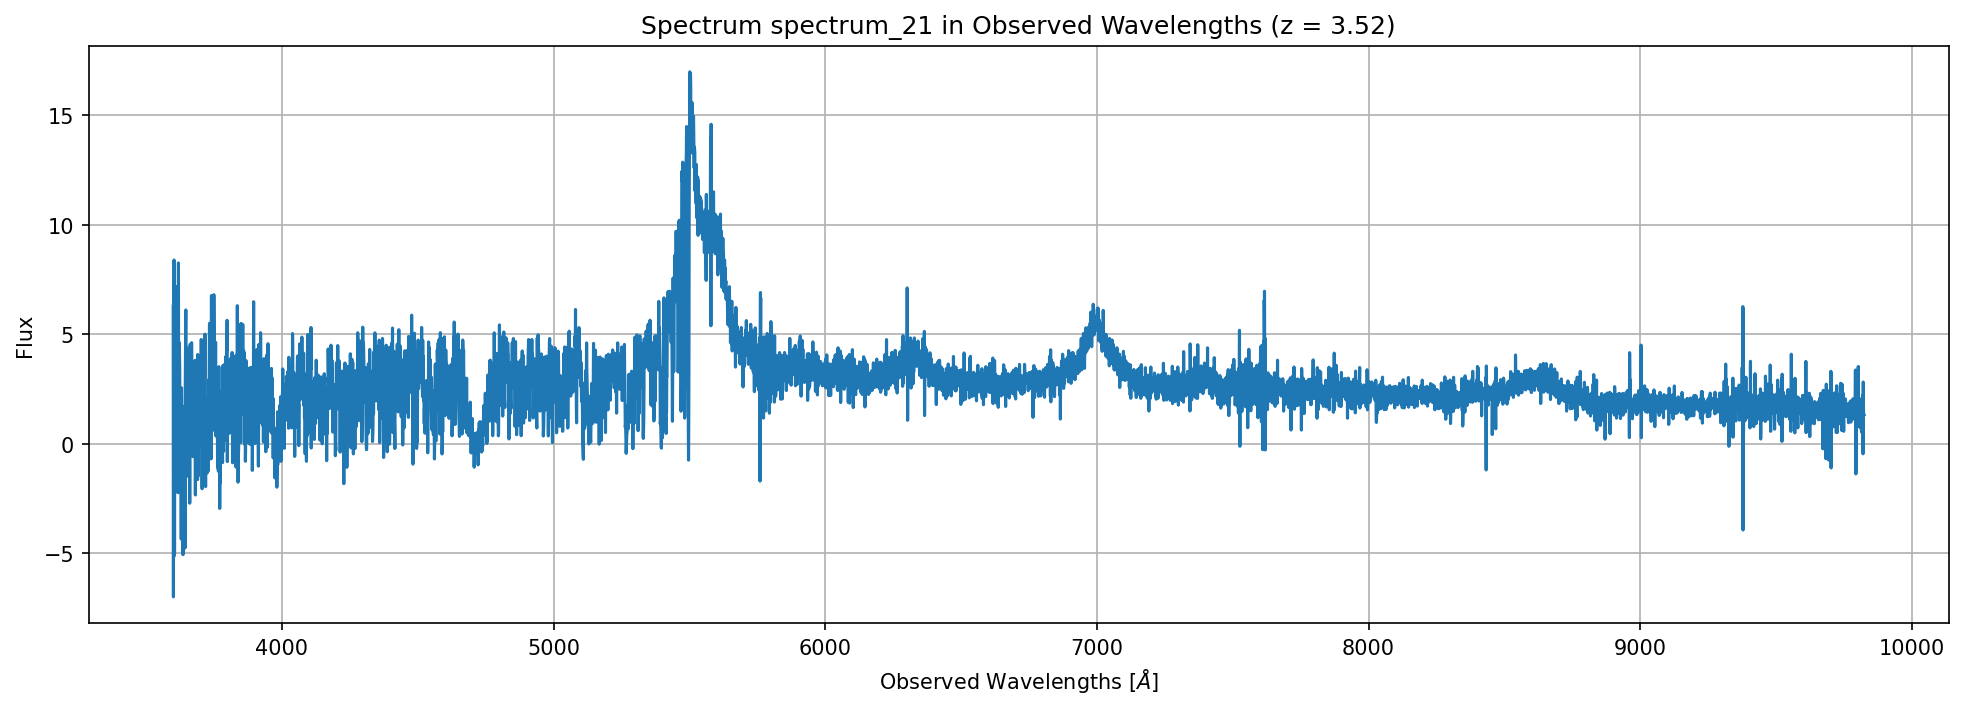

In [7]:
# Find the first high SNR and z > 3.2 spectrum
spectrum_id, spectrum_data, z_qso = find_high_snr_z_spectrum(reader, snr_threshold=5, redshift_threshold=3.4)

if spectrum_id:
    # Access wavelengths, flux, and noise variance from the DESI reader
    wavelengths = spectrum_data.wavelengths
    flux = spectrum_data.flux
    noise_variance = spectrum_data.noise_variance
    pixel_mask = spectrum_data.pixel_mask
    
    rest_wavelengths = wavelengths / (1 + z_qso)

    # Plot the spectrum in "observed wavelengths"
    plt.figure(figsize=(16, 5))
    plt.plot(wavelengths, flux)
    plt.xlabel("Observed Wavelengths [$\AA$]")
    plt.ylabel("Flux")
    plt.title(f"Spectrum {spectrum_id} in Observed Wavelengths (z = {z_qso:.2f})")
    plt.grid(True)
    plt.show()

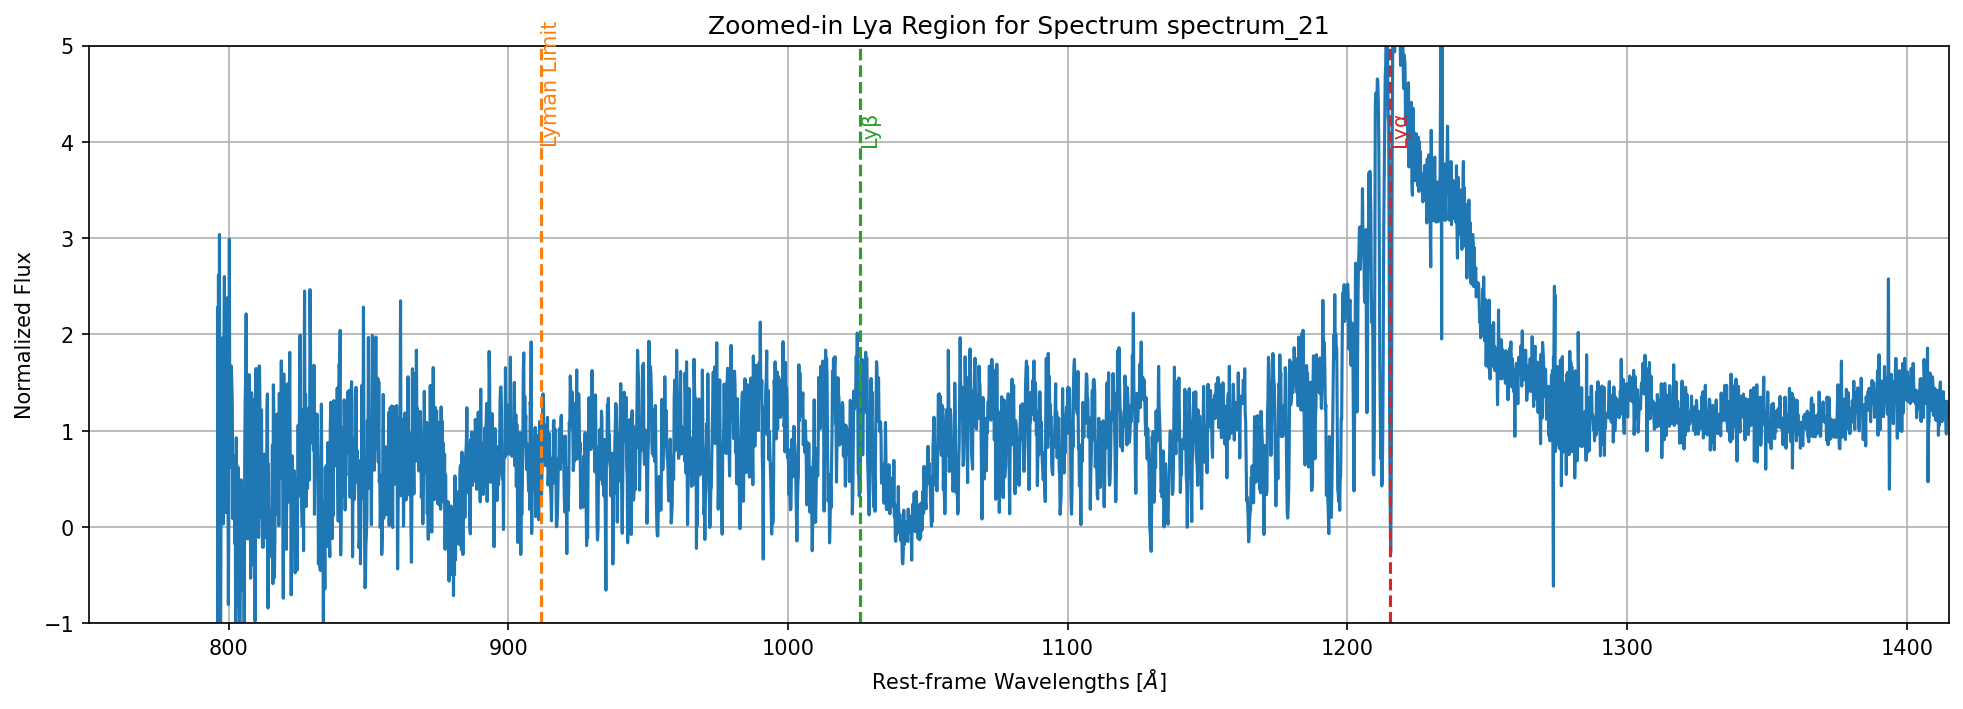

In [8]:
# Emission lines for Lyα, Lyβ, and Lyman Limit
lya_wavelength = 1215.24
lyb_wavelength = 1025.72
ly_limit_wavelength = 911.76

# Zoom in on the Lyα region (wavelengths 900 Å to 1216 Å)
plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, flux / np.mean(flux))
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-1, 5)
plt.xlim(750, 1415)
plt.title(f"Zoomed-in Lya Region for Spectrum {spectrum_id}")
plt.grid(True)

# Highlight the Lyα, Lyβ, and Lyman Limit emission lines
plt.vlines(lya_wavelength, -1, 5, color="C3", ls="--")
plt.text(lya_wavelength, 4, r"Lyα", rotation="vertical", color="C3")

plt.vlines(lyb_wavelength, -1, 5, color="C2", ls="--")
plt.text(lyb_wavelength, 4, r"Lyβ", rotation="vertical", color="C2")

plt.vlines(ly_limit_wavelength, -1, 5, color="C1", ls="--")
plt.text(ly_limit_wavelength, 4, r"Lyman Limit", rotation="vertical", color="C1")

# Show the plot
plt.show()

# Tutorial: Automating DLA Detection with Gaussian Processes in DESI

author: Ming-Feng Ho (jibancat)


In this tutorial, we'll show you how to automate the detection of  DLA (log NHI = 20.3 - 23) in quasar spectra using Gaussian processes. I will make the tutorial flexible to adapt to any trained GP model and any prior can be used.

## Understand how to use Bayesian model selection

Bayesian model selection provides a way to compare the performance of different models in a Bayesian way.
For a good lecture, mathmaticalmonk provides a nice [video](https://youtu.be/1CFof6hU3cI).
In a nutshell, you can think Bayesian model selection as a Bayesian way to do hypothesis testing.

Suppose you have two hypothesis: $M_1$ and $M_2$.
Each model has some capability to explain the data, $\mathcal{D}$.
The probability that $M_1$ can explain the data is $p(\mathcal{D} \mid M_1)$, and vice versa.
This probability, the ability of hypothesis explaining a given data, is also called "likelihood".

However, likelihoods are not the whole story.
We need to consider the fact that the $M_1$ and $M_2$ have different occurrence rates, i.e., one of the hypothesis might be rarer happened than the other one.
For example, the number of people who have cancers is less than people who don't, so the hypothsis of a person having a cancer should be assigned a smaller probability.
When you don't consider the base rate, you might misinterpret the results.
This is often called the [base-rate fallacy](https://en.wikipedia.org/wiki/Base_rate).




In some scientific domains, people claim that a p-value smaller than 0.05 is required to reject the null hypothesis. However, as a Bayesian, we prefer to express the problem in a Bayesian way, which takes into account the effects of the base-rate fallacy.

In Bayesian statistics, we can incorporate the prior probabilities, which are the probabilities of the hypotheses, $p(M)$. The prior probability is essentially the occurrence of the hypothesis or how common it is. With prior probabilities, we can calculate the posterior probability of the hypothesis, which is how likely it is that the hypothesis is true. For example, if $M_1$ is the null hypothesis with a prior probability of $p(M_1) = 0.95$, this means that it occurs more often than the other hypothesis.

The likelihood of $M_2$ needs to be $p(\mathcal{D} \mid M_2) > 0.95$ to make the hypothesis $M_2$ more likely than $M_1$. To calculate the posterior probability of $M_2$, we can use the formula:
$$
p(M_1 \mid \mathcal{D}) = \frac{p(M_1) p(\mathcal{D} \mid M_1)}{ p(M_1) p(\mathcal{D} \mid M_1) + p(M_2) p(\mathcal{D} \mid M_2) }
$$
Note that $p(M_2) = 1 - p(M_1) = 0.05$.

This means that the likelihood of $M_1$ is less than 0.05, which is almost equivalent to saying that the p-value (likelihood in the Bayesian sense) is less than 0.05.

In the following tutorial, we will use Bayesian model selection to find spectra with Lyman alpha absorbers. It is important to note that in Bayesian statistics, models and hypotheses are interchangeable.



In [9]:
%%time

# Import the required functions and classes
from run_bayes_select import process_single_spectrum

from gpy_dla_detection.set_parameters import Parameters
from gpy_dla_detection.model_priors import PriorCatalog
from gpy_dla_detection.dla_samples import DLASamplesMAT
from gpy_dla_detection.subdla_samples import SubDLASamplesMAT
from gpy_dla_detection.bayesian_model_selection import BayesModelSelect
from gpy_dla_detection.desi_spectrum_reader import DESISpectrumReader
from gpy_dla_detection.process_helpers import initialize_results, save_results_to_hdf5

from gpy_dla_detection.null_gp import NullGPMAT
from gpy_dla_detection.dla_gp import DLAGPMAT
from gpy_dla_detection.subdla_gp import SubDLAGPMAT

# Importing NumPy for initialization
import numpy as np

# Define the paths to your necessary files
# spectra_filename = "path/to/desi/spectra-16-705.fits"  # Replace with your actual path
# zbest_filename = "path/to/desi/zbest-16-705.fits"       # Replace with your actual path
learned_file = "data/dr12q/processed/learned_qso_model_lyseries_variance_wmu_boss_dr16q_minus_dr12q_gp_851-1421.mat"
catalog_name = "data/dr12q/processed/catalog.mat"
los_catalog = "data/dla_catalogs/dr9q_concordance/processed/los_catalog"
dla_catalog = "data/dla_catalogs/dr9q_concordance/processed/dla_catalog"
dla_samples_file = "data/dr12q/processed/dla_samples_a03.mat"
sub_dla_samples_file = "data/dr12q/processed/subdla_samples.mat"

# Set parameters dynamically, including max_dlas
max_dlas = 3  # Can change this value to reflect how many DLA models you want to process
min_z_separation = 3000.0  # Minimum redshift separation for DLA models
prev_tau_0 = 0.00554
prev_beta = 3.182

# Initialize required classes and files
params = Parameters(
    loading_min_lambda=800,  # range of rest wavelengths to load (Å)
    loading_max_lambda=1550,
    normalization_min_lambda=1425,  # range of rest wavelengths to use (Å)
    normalization_max_lambda=1475,  # for flux normalization
    min_lambda=850.75,  # range of rest wavelengths to model (Å)
    max_lambda=1420.75,
    dlambda=0.25,  # separation of wavelength grid (Å)
    k=20,  # rank of non-diagonal contribution
    max_noise_variance=3 ** 2,  # maximum pixel noise allowed during model training
)

prior = PriorCatalog(params, catalog_name, los_catalog, dla_catalog)
dla_samples = DLASamplesMAT(params, prior, dla_samples_file)
subdla_samples = SubDLASamplesMAT(params, prior, sub_dla_samples_file)

# Initialize the Bayesian Model Selection object with max_dlas
bayes = BayesModelSelect([0, 1, max_dlas], 2)

# # Read the DESI spectrum and redshift catalog
# reader = DESISpectrumReader(spectra_filename, zbest_filename)
# reader.read_spectra()
# reader.read_redshift_catalog()

# # Get the first spectrum ID and its redshift
# spectrum_id = reader.get_all_spectrum_ids()[0]  # Use the first spectrum for this example
# spectrum_data = reader.get_spectrum_data(spectrum_id)
z_qso = reader.get_redshift_data()['Z'][0]  # Corresponding redshift

# # Set variables for this spectrum
# wavelengths = spectrum_data.wavelengths
# flux = spectrum_data.flux
# noise_variance = spectrum_data.noise_variance
# pixel_mask = spectrum_data.pixel_mask
# rest_wavelengths = params.emitted_wavelengths(wavelengths, z_qso)


# Instantiate the models
null_gp = NullGPMAT(
    params, prior, learned_file=learned_file, prev_tau_0=prev_tau_0, prev_beta=prev_beta
)

dla_gp = DLAGPMAT(
    params=params,
    prior=prior,
    dla_samples=dla_samples,
    min_z_separation=min_z_separation,
    learned_file=learned_file,
    broadening=True,
    prev_tau_0=prev_tau_0,
    prev_beta=prev_beta,
)

subdla_gp = SubDLAGPMAT(
    params=params,
    prior=prior,
    dla_samples=subdla_samples,
    min_z_separation=min_z_separation,
    learned_file=learned_file,
    broadening=True,
    prev_tau_0=prev_tau_0,
    prev_beta=prev_beta,
)


# Initialize an empty dictionary to store results, adjusted for max_dlas
num_spectra = 1  # Just for demo
results = initialize_results(num_spectra, max_dlas, params.num_dla_samples)

# Run the process for the single spectrum
process_single_spectrum(
    idx=0,
    spectrum_id=spectrum_id,
    z_qso=z_qso,
    wavelengths=wavelengths,
    rest_wavelengths=rest_wavelengths,
    flux=flux,
    noise_variance=noise_variance,
    pixel_mask=pixel_mask,
    params=params,
    prior=prior,
    dla_samples=dla_samples,
    subdla_samples=subdla_samples,
    bayes=bayes,
    results=results,
    max_dlas=max_dlas,  # Use the dynamic max_dlas
    broadening=True,
    gp=null_gp,  # Pass the pre-created NullGPMAT object
    dla_gp=dla_gp,  # Pass the pre-created DLAGPMAT object
    subdla_gp=subdla_gp,  # Pass the pre-created SubDLAGPMAT object
    min_z_separation=min_z_separation,
    plot_figures=False,
    max_workers=32,  # Parallel processing with 4 workers
    batch_size=313,
)

# Display the processed results for this spectrum
print("Processed results for Spectrum ID:", spectrum_id)
print("Minimum z_dla:", results['min_z_dlas'][0])
print("Maximum z_dla:", results['max_z_dlas'][0])
print("Log priors (no DLA):", results['log_priors_no_dla'][0])
print("Log posteriors (DLA):", results['log_posteriors_dla'][0])

# You can also add additional visualizations or save the results based on your needs.

Processed results for Spectrum ID: spectrum_21
Minimum z_dla: 2.41371959601573
Maximum z_dla: 3.5282232578844117
Log priors (no DLA): -0.1685601534091805
Log posteriors (DLA): [-1235.62608533 -1237.96840587 -1264.74415934]
CPU times: user 905 ms, sys: 1.55 s, total: 2.46 s
Wall time: 5.34 s


In [10]:
print("p(Null) = ", results["model_posteriors"][0, 0])
print("p(SubDLA/Alternative) = ", results["model_posteriors"][0, 1])
print("p(DLA+) = ", results["model_posteriors"][0, 2:])

p(Null) =  4.408950292798267e-97
p(SubDLA/Alternative) =  8.340622905235888e-67
p(DLA+) =  [9.12321884e-01 8.76781161e-02 2.06219262e-13]


## Visualizations

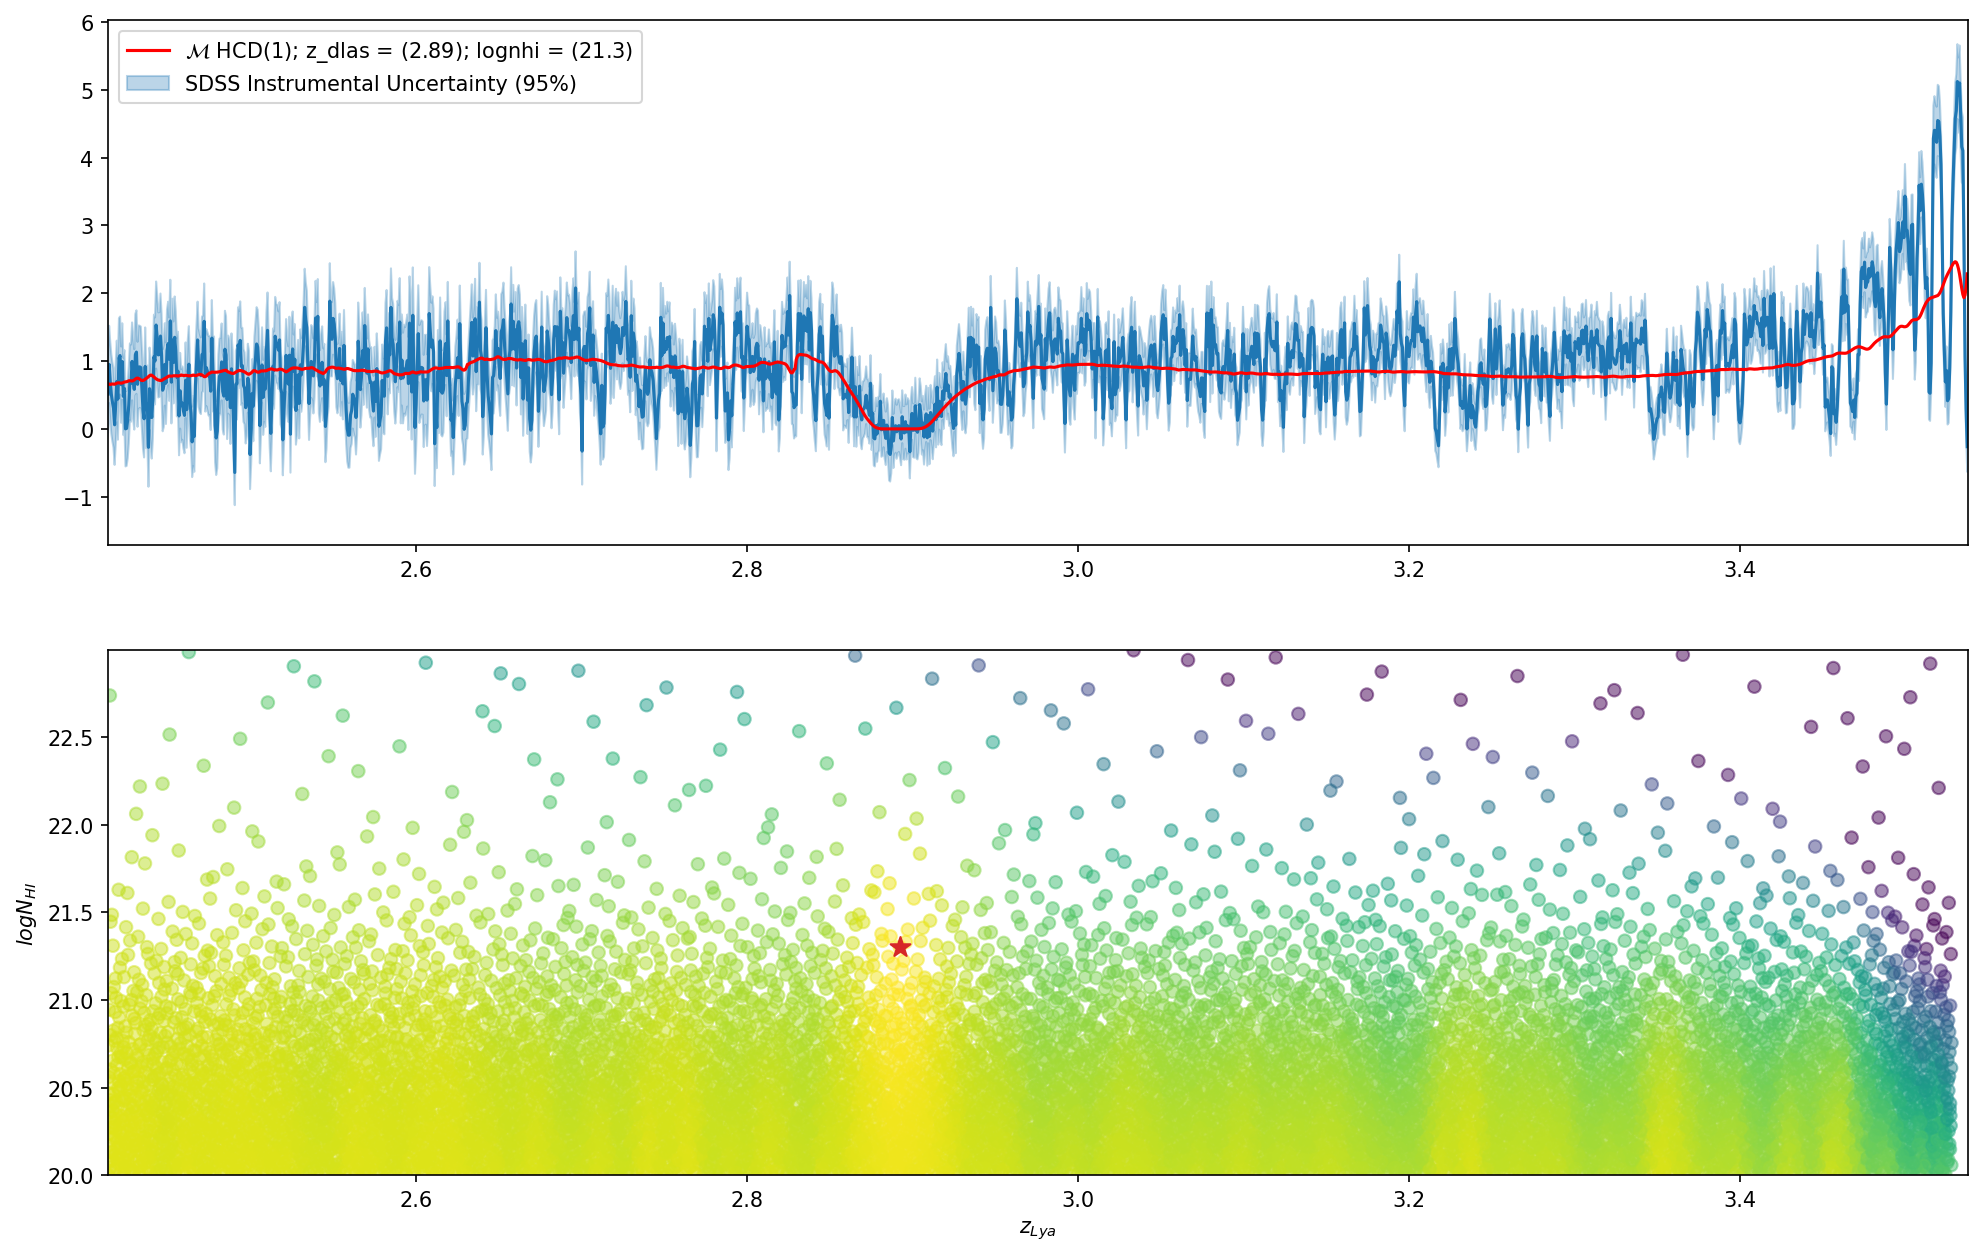

In [11]:
# How many absorbers searches you want to plot
if bayes.p_dla > 0.9:
    nth_lya = 1 + results["model_posteriors"][0, 2:].argmax() # here we plot all of the searches
else:
    nth_lya = 0

lya_gp = dla_gp
gp = null_gp
    
sample_z_dlas = lya_gp.dla_samples.sample_z_dlas(
        lya_gp.this_wavelengths, lya_gp.z_qso
)

# [color sequence] convert sample log likelihoods to values in (0, 1)
sample_log_likelihoods = lya_gp.sample_log_likelihoods[
    :, 0
]  # only query the DLA(1) likelihoods
# TODO: marginalize over k DLAs
max_like = np.nanmax(sample_log_likelihoods)
min_like = np.nanmin(sample_log_likelihoods)

colours = (sample_log_likelihoods - min_like) / (max_like - min_like)

# scale to make the colour more visible
# TODO: make it more reasonable. scatter only takes values between [0, 1].
colours = colours * 5 - 4
colours[colours < 0] = 0


# Canvas with two panels
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

# 1. Real spectrum space
# N * (1~k models) * (1~k MAP dlas)
MAP_z_dla, MAP_log_nhi = lya_gp.maximum_a_posteriori()
# make them to be 1-D array
map_z_dlas = MAP_z_dla[nth_lya - 1, :nth_lya]
map_log_nhis = MAP_log_nhi[nth_lya - 1, :nth_lya]
# feed in MAP values and get the absorption profile given (z_dlas, nhis)
lya_mu, lya_M, lya_omega2 = lya_gp.this_dla_gp(map_z_dlas, 10 ** map_log_nhis)

# Only plot the spectrum within the search range
this_rest_wavelengths = lya_gp.x
ind = (this_rest_wavelengths < lya_gp.params.lya_wavelength)

this_rest_wavelengths = this_rest_wavelengths[ind]
lya_mu = lya_mu[ind]

ax[0].plot(
    (this_rest_wavelengths * (1 + z_qso)) / lya_gp.params.lya_wavelength - 1,
    lya_gp.Y[ind]
)
ax[0].plot(
    (this_rest_wavelengths * (1 + z_qso)) / lya_gp.params.lya_wavelength - 1,
    lya_mu,
    label=r"$\mathcal{M}$"
    + r" HCD({n}); ".format(n=nth_lya)
    + "z_dlas = ({}); ".format(",".join("{:.3g}".format(z) for z in map_z_dlas))
    + "lognhi = ({})".format(
        ",".join("{:.3g}".format(n) for n in map_log_nhis)
    ),
    color="red",
)
ax[0].fill_between(
    (this_rest_wavelengths * (1 + z_qso)) / lya_gp.params.lya_wavelength - 1,
    gp.Y[ind] - 2*np.sqrt(gp.v[ind]),
    gp.Y[ind] + 2*np.sqrt(gp.v[ind]),
    label="SDSS Instrumental Uncertainty (95%)",
    color="C0",
    alpha=0.3,
)


# 2. Posterior space
ax[1].scatter(
    sample_z_dlas, lya_gp.dla_samples.log_nhi_samples, c=colours,
    marker="o", alpha=0.5,
)
# MAP estimate
ax[1].scatter(
    map_z_dlas, map_log_nhis,
    marker="*",
    s=100,
    color="C3",
)

# [min max sample zDLAs] instead of using min max from sample_z_dlas
# using the zDLAs converted from wavelengths will better reflect the
# range of wavelengths range in the this_mu plot.
ax[1].set_xlim(sample_z_dlas.min(), z_qso)
ax[1].set_ylim(
    lya_gp.dla_samples.log_nhi_samples.min(),
    lya_gp.dla_samples.log_nhi_samples.max(),
)
ax[1].set_xlabel(r"$z_{Lya}$")
ax[1].set_ylabel(r"$log N_{HI}$")

# You want the first panel has the same range
ax[0].set_xlim(sample_z_dlas.min(), z_qso)
ax[0].legend()

(-1.0, 5.0)

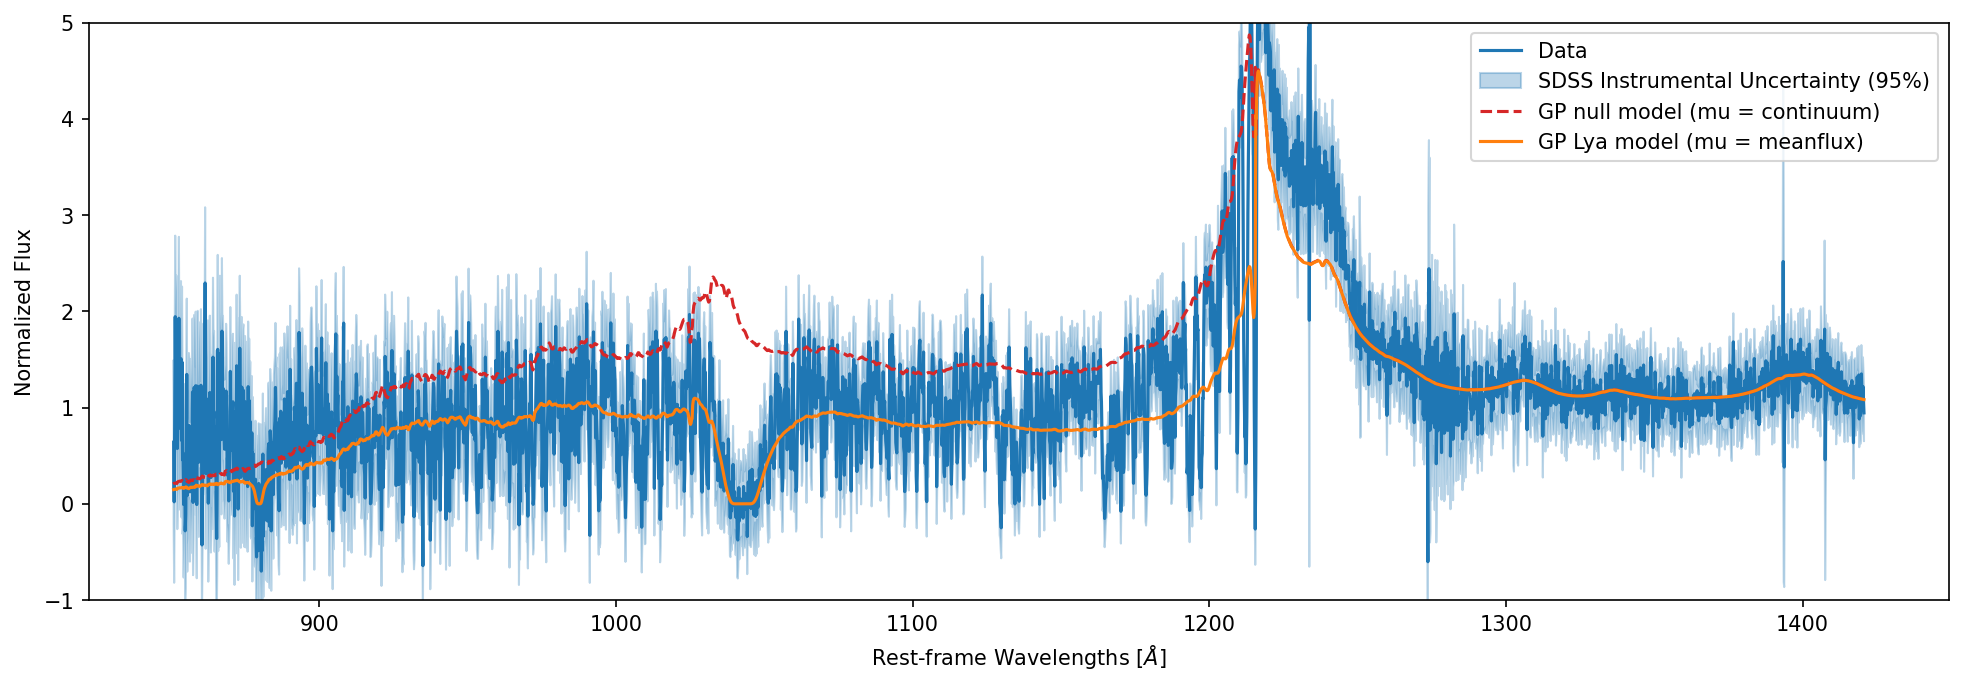

In [12]:
# 1. Real spectrum space
# N * (1~k models) * (1~k MAP dlas)
MAP_z_dla, MAP_log_nhi = lya_gp.maximum_a_posteriori()
# make them to be 1-D array
map_z_dlas = MAP_z_dla[nth_lya - 1, :nth_lya]
map_log_nhis = MAP_log_nhi[nth_lya - 1, :nth_lya]
# feed in MAP values and get the absorption profile given (z_dlas, nhis)
lya_mu, lya_M, lya_omega2 = lya_gp.this_dla_gp(map_z_dlas, 10 ** map_log_nhis)

plt.figure(figsize=(16, 5))

# Mean function
plt.plot(
    gp.X, # quasar spectrum's rest-frame wavelengths
    gp.Y, # quasar spectrum's flux
    label="Data",
)
plt.fill_between(
    gp.X,
    gp.Y - 2*np.sqrt(gp.v),
    gp.Y + 2*np.sqrt(gp.v),
    label="SDSS Instrumental Uncertainty (95%)",
    color="C0",
    alpha=0.3,
)
plt.plot(
    gp.rest_wavelengths,
    gp.mu,
    label="GP null model (mu = continuum)",
    color="C3",
    ls="--"
)
plt.plot(
    gp.X,
    lya_mu, # GP model's mean function
    label="GP Lya model (mu = meanflux)"
)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.legend()
plt.ylim(-1, 5)

## Profiling

In [13]:
%%prun
process_single_spectrum(
    idx=0,
    spectrum_id=spectrum_id,
    z_qso=z_qso,
    wavelengths=wavelengths,
    rest_wavelengths=rest_wavelengths,
    flux=flux,
    noise_variance=noise_variance,
    pixel_mask=pixel_mask,
    params=params,
    prior=prior,
    dla_samples=dla_samples,
    subdla_samples=subdla_samples,
    bayes=bayes,
    results=results,
    max_dlas=max_dlas,  # Use the dynamic max_dlas
    broadening=True,
    gp=null_gp,  # Pass the pre-created NullGPMAT object
    dla_gp=dla_gp,  # Pass the pre-created DLAGPMAT object
    subdla_gp=subdla_gp,  # Pass the pre-created SubDLAGPMAT object
    min_z_separation=min_z_separation,
    plot_figures=False,
    max_workers=32,  # Parallel processing with 4 workers
    batch_size=313,
)

         35748 function calls (35623 primitive calls) in 4.441 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2440    3.836    0.002    3.836    0.002 {method 'acquire' of '_thread.lock' objects}
      128    0.439    0.003    0.442    0.003 {built-in method posix.fork}
        6    0.017    0.003    0.017    0.003 effective_optical_depth.py:10(effective_optical_depth)
        2    0.012    0.006    4.414    2.207 dla_gp.py:346(parallel_log_model_evidences)
      128    0.010    0.000    0.460    0.004 popen_fork.py:62(_launch)
      128    0.008    0.000    0.011    0.000 process.py:80(__init__)
      128    0.007    0.000    0.628    0.005 context.py:278(_Popen)
      256    0.007    0.000    0.155    0.001 iostream.py:592(flush)
      512    0.007    0.000    0.007    0.000 socket.py:626(send)
      128    0.006    0.000    0.643    0.005 process.py:110(start)
      128    0.006    0.000    0.006    0.000 util.py:1